## Match Prediction Notebook

23 feature data dscription


* Season-	Match Season
* DateTime-	Match Date and Time (yyyy-mm-dd hh:mm:ss)
* HomeTeam-	Home Team
* AwayTeam-	Away Team
* FTHG-	Full Time Home Team Goals
* FTAG-	Full Time Away Team Goals
* FTR	-Full Time Result (H=Home Win, D=Draw, A=Away Win)
* HTHG-	Half Time Home Team Goals
* HTAG-	Half Time Away Team Goals
* HTR-Half Time Result (H=Home Win, D=Draw, A=Away Win)
* Referee-	Match Referee
* HS-	Home Team Shots
* AS-	Away Team Shots
* HST-	Home Team Shots on Target
* AST-	Away Team Shots on Target
* HC-	Home Team Corners
* AC-	Away Team Corners
* HF-	Home Team Fouls Committed
* AF-	Away Team Fouls Committed
* HY-	Home Team Yellow Cards
* AY-	Away Team Yellow Cards
* HR-	Home Team Red Cards
* AR-	Away Team Red Cards

In [1]:
# lemme check some of the attributes of the dataframe
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import warnings
warnings.simplefilter(action='ignore')

#loading data
data=pd.read_csv(r"epl_23-f.csv",encoding='windows-1254')
data.columns=[i.lower() for i in data.columns]
data

,season,datetime,hometeam,awayteam,fthg,ftag,ftr,hthg,htag,htr,...,hst,ast,hc,ac,hf,af,hy,ay,hr,ar
0,1993-94,1993-08-14T00:00:00Z,Arsenal,Coventry,0,3,A,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1993-94,1993-08-14T00:00:00Z,Aston Villa,QPR,4,1,H,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1993-94,1993-08-14T00:00:00Z,Chelsea,Blackburn,1,2,A,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1993-94,1993-08-14T00:00:00Z,Liverpool,Sheffield Weds,2,0,H,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1993-94,1993-08-14T00:00:00Z,Man City,Leeds,1,1,D,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11108,2021-22,2022-04-09T17:30:00Z,Aston Villa,Tottenham,0,4,A,0.0,1.0,A,...,8.0,5.0,9.0,3.0,12.0,14.0,2.0,3.0,0.0,0.0
11109,2021-22,2022-04-10T14:00:00Z,Brentford,West Ham,2,0,H,0.0,0.0,D,...,7.0,1.0,4.0,6.0,2.0,6.0,0.0,1.0,0.0,0.0
11110,2021-22,2022-04-10T14:00:00Z,Leicester,Crystal Palace,2,1,H,2.0,0.0,H,...,3.0,3.0,3.0,4.0,11.0,12.0,1.0,1.0,0.0,0.0
11111,2021-22,2022-04-10T14:00:00Z,Norwich,Burnley,2,0,H,1.0,0.0,H,...,6.0,4.0,6.0,7.0,12.0,10.0,1.0,1.0,0.0,0.0


In [2]:
# seeing which of the seasons got null values and cuz i dont potentially want any season having null values in it
# data.groupby('season').apply(lambda x : x.isna().sum().sum())
# 2000-01 -till the end of the data no null

In [3]:
from statsmodels.tsa.deterministic import DeterministicProcess
data.drop(data.loc[data['season'].str.contains('1993|1994|1995|1996|1997|1998|1999',regex=True)].index,inplace=True)

In [4]:
import datetime as dt
def season_datetime_fix(data):
    data[['week','dayofseason','date_dummy']]= "" 
    data.datetime=pd.to_datetime(data.datetime).dt.date
    for season in data.season.unique():
        season_data=data[data['season']==season]
        start=season_data.iloc[0].datetime
        year=start.year
        delta=start-dt.date(year,1,1)
        season_data['date_dummy']=season_data.datetime-delta
        season_data.week=season_data.date_dummy.apply(lambda x:x.isocalendar()[1])
        season_data.dayofseason=season_data.date_dummy.apply(lambda x: x.timetuple().tm_yday)
#         season_data.drop('date_dummy',axis=1,inplace=True)
        data[data.season==season]=season_data
    data['day']=data['datetime'].apply(lambda x:x.isoweekday())
    return data

data=season_datetime_fix(data)

In [5]:
# df=data[data.season=='2000-01']
# df['mean_hs_week']=df.groupby('week')['hs'].transform('mean')
# sns.scatterplot(df.week,df.mean_hs_week);

In [6]:
s_data=data.select_dtypes('number')
from sklearn.preprocessing import StandardScaler,MinMaxScaler,OrdinalEncoder
from sklearn.model_selection import train_test_split,cross_val_predict,cross_val_score
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer,make_column_transformer,make_column_selector
from sklearn.ensemble import RandomForestClassifier
trainx,testx,trainy,testy=train_test_split(s_data.drop('hs',axis=1),s_data.hs,test_size=0.2,random_state=42)

In [7]:
# data.dtypes

In [8]:

# justa a atest never mind
# checking out if referrees got anything to do with number of fouls
df=data.copy()
df['rf_sum']=''
df['rf_sum']=df.groupby('referee')['hs'].transform('sum')
index_=list(data.referee.value_counts().index)
values_=list(data.referee.value_counts().values)
df['ref_app']=df['referee']
mapper={index_[i]:values_[i] for i in range(len(index_))}
df.ref_app=df.ref_app.map(mapper)
df[['ref_app','referee','rf_sum']]
df['av_fg']=df['rf_sum']/df['ref_app']
df[['referee','av_fg']].value_counts()

referee       av_fg    
M Dean        14.013384    523
M Atkinson    13.753304    454
A Marriner    13.814324    377
M Oliver      14.215190    316
A Taylor      13.983819    309
                          ... 
I Williamson  12.000000      1
St Bennett    8.000000       1
M. L. Dean    14.000000      1
F Taylor      12.000000      1
 U Rennie     13.000000      1
Length: 158, dtype: int64

In [9]:
# from sklearn.preprocessing import OrdinalEncoder
# oe=OrdinalEncoder(handle_unknown='error')
# df['referee']=oe.fit_transform(pd.DataFrame(df['referee']))
# sns.barplot(df.corr()['referee'].index,df.corr()['referee'].values)
# df.corr()['referee'].sort_values(ascending=True).index

In [10]:
data.isna().sum().sum()

0

# points to ponder
* features base -anything
* problem is multi output regression:-must be simple
* data cleaning - algorithm specific
*    ~ what am i thinking of applying?
*    random forest regresion - not a typycal one
*    linear regresion 
* 
* ~need time series features now-- How to make all of them?

### time series features
~time step features aand lag features
-time dummy=time step feature
-any lag feature


In [11]:
num_data=data.select_dtypes('number')

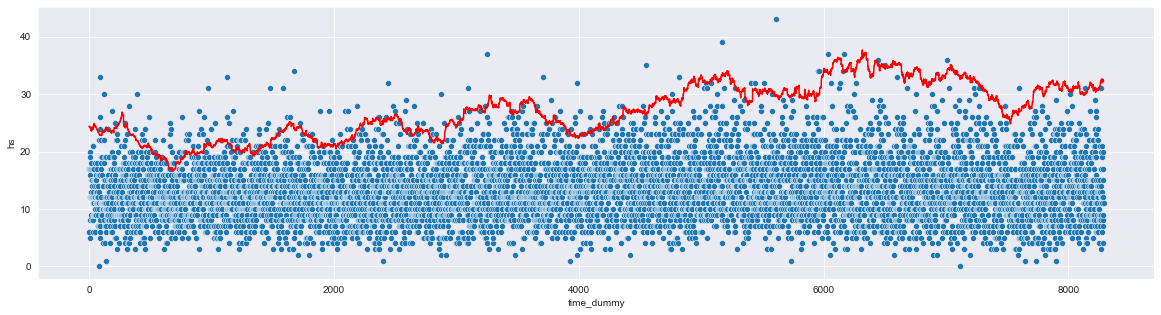

In [12]:
data['time_dummy']=np.arange(len(data))
plt.figure(figsize=(20,5))

sns.scatterplot(data['time_dummy'],data.hs)
r_av=data.hs.rolling(
    window=380,
    center=True,
    min_periods=191
).var()
# change the fianl functsion to change the calacualation



plt.plot(data['time_dummy'],r_av,'r-');


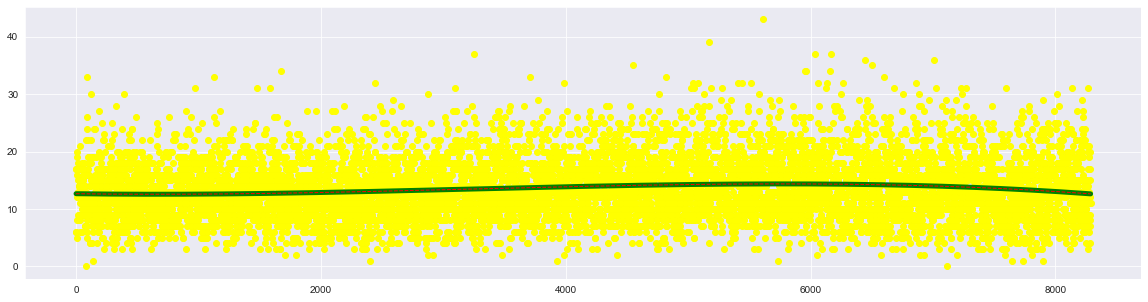

In [13]:
# automatic time series features for one season of epl for all numerical data types
# taking one feature and seeing if higher orders explain lower order relation
from statsmodels.tsa.deterministic import DeterministicProcess
from sklearn.linear_model import LinearRegression

ftr=data['hs']
dp=DeterministicProcess(
    index=data.date_dummy,
    constant=True,
    order=3,
    drop=True
)
x=dp.in_sample()
y=data.hs
plt.figure(figsize=(20,5))
plt.scatter(data['time_dummy'],data.hs,color='Yellow')
lr=LinearRegression()
lr.fit(x,y)
plt.plot(data['time_dummy'],lr.predict(x),'g-',linewidth=5)

dp2=DeterministicProcess(
    index=data.date_dummy,
    constant=True,
    order=10,
    drop=True)

x=dp.in_sample()
y=data.hs

lr=LinearRegression()
lr.fit(x,y)
plt.plot(data['time_dummy'],lr.predict(x),'r--',linewidth=1);

In [14]:
# trend feature for all of the numerical columns using a dummy dimeansion of 10
def dummy_feature_for_num(data):
    num_data=data.select_dtypes('number')
    dp=DeterministicProcess(
        index=data.date_dummy,
        constant=True,
        order=10,
        drop=True)
    
    for column in num_data.columns:
        if column!='time_dummy':
            y=data[column]
            x=dp.in_sample()
            lr=LinearRegression()
            lr.fit(x,y)
            feature=lr.predict(x)
            string=column+'_tnd'
            data[string]=feature
    return data



# another interesting thing is the motion of avarage variance in any attribute - seems so much rigurous and seems to contain a lot of seasonal changes
# i am gonna treat it as a separate feature and then i'll estimate this feature over time dummy using linear regression
# more like variance trend


'''we wil make variance feature first and then we will estimate that feature using regression 
        you can either keep both the variance feature and its estimate or just keep the esrimate as a feature ain the out'''

def estimate_variance_of_features(data,features,keep_both_features=None):
    var_est=pd.DataFrame()
    var=pd.DataFrame()
    for feature in features:
        var_of_feature=data[feature].rolling(
            window=380, #assuming feature could be having a football seasons season
            center=True,
            min_periods=191,
        ).var()
        string=feature+'_var'
        var[string]=var_of_feature
        dp=DeterministicProcess(
            index=data.date_dummy,
            constant=True,
            order=10,
            drop=True
        )
        x=dp.in_sample()
        y=var_of_feature
        fill=y.mean()
        y.fillna(fill,inplace=True)
        lr.fit(x,y)
        est_var_feature=lr.predict(x)
        string=feature+'_var_'+'tnd'
        var_est[string]=est_var_feature

    var_est.reset_index(drop=True)
    if keep_both_features==True:
        all_faetures=var_est.join(var.reset_index(drop=True))
    else:
        all_faetures=var_est
    return all_faetures

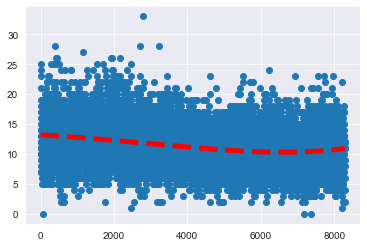

In [15]:
# testing func1
# avalidating the above code -just made a plot- dont care
data=dummy_feature_for_num(data)
plt.scatter(data.time_dummy,data.hf)
plt.plot(data.time_dummy,data.hf_tnd,'r--',linewidth=5);

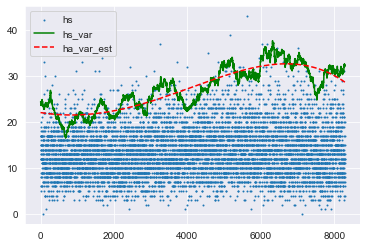

In [16]:
# testing func2
ff=estimate_variance_of_features(data,['hs'],keep_both_features=True)
plt.scatter(data.time_dummy,data.hs,s=1)
plt.plot(data.time_dummy,ff.hs_var,'g-')
plt.plot(data.time_dummy,ff.hs_var_tnd,'r--')
plt.legend(['hs','hs_var','ha_var_est']);


In [17]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

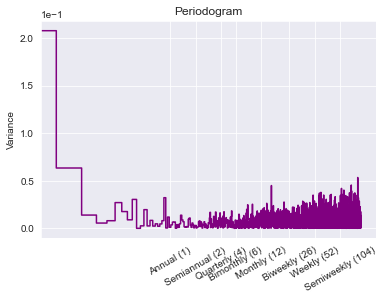

In [18]:
plot_periodogram(data.hs);

## facebook prophet

In [19]:
from prophet import Prophet
m=Prophet()
m.fit(dt)
dt[['ds','y']]=data[['datetime','hs']]

TypeError: argument of type 'module' is not iterable

In [ ]:
data.columns

Index(['season', 'datetime', 'hometeam', 'awayteam', 'fthg', 'ftag', 'ftr',
       'hthg', 'htag', 'htr', 'referee', 'hs', 'as', 'hst', 'ast', 'hc', 'ac',
       'hf', 'af', 'hy', 'ay', 'hr', 'ar', 'week', 'dayofseason', 'date_dummy',
       'day'],
      dtype='object')

In [ ]:
#### non time series
# season
# datetime
# homwteam
# awayteam

#### time series
# 

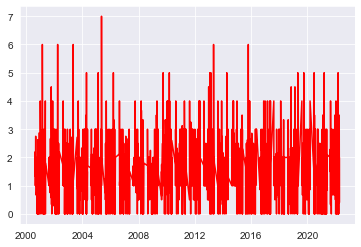

In [ ]:

# hypo- does time has anything to do with fthg ofcourse it does 
data['md_mean_g']=data.groupby('datetime')['fthg'].transform('mean')
plt.plot(data.datetime,data.md_mean_g,'r-')

In [ ]:
from sklearn.linear_model import LinearRegression
lr=LinearRegression()
x=data.select_dtypes('number').drop(['fthg','ftag'],axis=1)
y=data[['fthg','ftag']]
lr.fit(x,y)
lr.predict(x)

array([[3.82396777, 0.52282365],
       [2.25407713, 0.65121644],
       [1.05599064, 2.58390662],
       ...,
       [2.52125197, 0.65257178],
       [1.75992786, 0.66501499],
       [2.88259745, 1.73507936]])

In [ ]:
sorted(y.fthg.unique())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [ ]:
# trying kmeans algo
xs=data.select_dtypes('number').drop(['time_dummy'],axis=1)
x=xs.drop(['fthg','ftag'],axis=1)
y=xs[['fthg','ftag']]
from sklearn.cluster import KMeans
clusters=len(y['fthg'].unique())
km=KMeans(n_clusters=clusters)
preds=km.fit_predict(x,y['fthg'])
preds

def error(preds,original):
    return (preds==original).sum()/len(preds)
error(preds,y['fthg'])

# linear regression
import math
lr.fit(x,y['fthg'])
preds=lr.predict(x)
preds=np.round(preds)
error(preds,y['fthg'])

0.13017251779466762

In [ ]:
# logistic regression
from sklearn.linear_model import LogisticRegression

# i think predicting just who wins is mid better prdiction is the home and away goals scored and can do a softmax regression
# and get probability for all the unique number of goals happened aagain happen in fthg or ftag
# again this depricates the possibility of scoring mor goals thats not happened ever say 25 goals
# can do a torch implementation
